In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [2]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/myData.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

In [3]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMG_COUNT = 480

In [5]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

# Only TS-1

In [8]:
#@title This cell is for composing the datasets as mentioned in the original paper

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []
image_dir_ms1 = '/content/data/RG'
mask_dir_ms1 = '/content/data/RGMask'

# 100% Manually Segmented
print("Selected Training Set 1")
print("Manually Segmented - 100% (480)")
# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir_ms1)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir_ms1, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir_ms1)):

    # Load the corresponding mask and resize to the target size
    mask = cv2.imread(os.path.join(mask_dir_ms1, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)


IMG_COUNT = len(images)
print(f"image count : {IMG_COUNT}")

Selected Training Set 1
Manually Segmented - 100% (480)
image count : 480


In [ ]:
# # Set the directories containing the images and masks
# image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/AG'
# mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/AGMask'

# # Set the target image size
# target_size = (IMG_WIDTH, IMG_HEIGHT)

# # Create empty lists to hold the images and masks
# images = []
# masks = []

# # Iterate through the directories and load the images and masks
# for file in sorted(os.listdir(image_dir)):
#     # Load the image and resize to the target size
#     img = cv2.imread(os.path.join(image_dir, file))
#     img = cv2.resize(img, target_size)

#     # Append the resized image to the list of images
#     images.append(img)

# for file in sorted(os.listdir(mask_dir)):

#     # Load the corresponding mask and resize to the target size
#     #mask_file = file.replace('.jpg', '.png')
#     mask = cv2.imread(os.path.join(mask_dir, file))
#     mask = cv2.resize(mask, target_size)

#     # Append the resized mask to the list of masks
#     masks.append(mask)

# IMG_COUNT = len(images)

# Example Image and it's Ground Truth

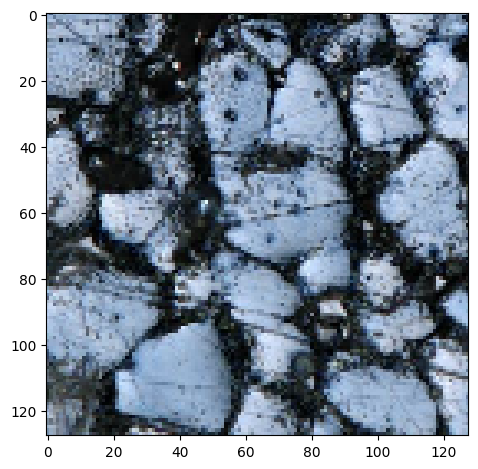

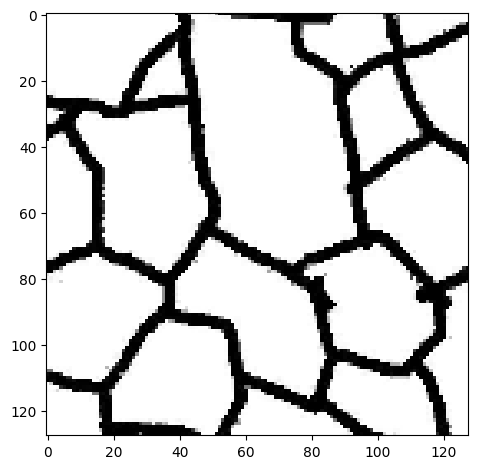

In [9]:
# example
image_x = random.randint(0, IMG_COUNT)
image_x
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

# dataset splitting

In [10]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(480, 128, 128, 3) (480, 128, 128, 3)


In [11]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(480, 3, 128, 128) (480, 3, 128, 128)


In [12]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(IMG_COUNT, 1, 128, 128)
print(Y_t.shape)


(480, 128, 128)
(480, 1, 128, 128)


In [13]:
# prompt: Make Dataset from data

from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(X_train, Y_t)



In [14]:
# prompt: create train and validation dataset

from torch.utils.data import random_split

# Split the dataset into train and validation sets (80-10-10)
train_size = int(0.80 * len(dataset))
r = len(dataset) - train_size
val_size = int(0.5 * r)
test_size = int(0.5 * r)
train_dataset, val_dataset,test_dataset = random_split(dataset, [train_size, val_size,test_size])



In [15]:
print(f"Train : {train_size}")
print(f"Val: {val_size}")
print(f"Test: {test_size}")

Train : 384
Val: 48
Test: 48


Device Agnostic code

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Unet Attention

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)

# Model summary
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
           Dropout-5         [-1, 16, 128, 128]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
          Dropout-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
             ReLU-14           [-1, 64,

In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/Unet Checkpoints/Unet-{TRAINING_SET}_{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'
# print(checkpoint_path)
# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(checkpoint_path)

# Assuming 'model' is already transferred to the appropriate device
# and 'device' is defined as 'cuda' if available, otherwise 'cpu'
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for inputs, targets in train_loader:
        # Move inputs and targets to the same device as the model
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass: compute the model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)  # Aggregate the loss

    # After training batches, compute the average loss
    train_loss /= len(train_loader.dataset)

    # Evaluate the model if necessary, make sure to move evaluation data to the same device
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    # checkpointer(model,epoch, train_loss, val_loss)


Epoch [1/20], Train Loss: 0.4594, Val Loss: 0.3966
Epoch [2/20], Train Loss: 0.3868, Val Loss: 0.3716
Epoch [3/20], Train Loss: 0.3724, Val Loss: 0.3637
Epoch [4/20], Train Loss: 0.3635, Val Loss: 0.3529
Epoch [5/20], Train Loss: 0.3525, Val Loss: 0.3457
Epoch [6/20], Train Loss: 0.3380, Val Loss: 0.3291
Epoch [7/20], Train Loss: 0.3245, Val Loss: 0.3168
Epoch [8/20], Train Loss: 0.3164, Val Loss: 0.3108
Epoch [9/20], Train Loss: 0.3113, Val Loss: 0.3085
Epoch [10/20], Train Loss: 0.3091, Val Loss: 0.3044
Epoch [11/20], Train Loss: 0.3045, Val Loss: 0.3014
Epoch [12/20], Train Loss: 0.3026, Val Loss: 0.3013
Epoch [13/20], Train Loss: 0.3038, Val Loss: 0.3022
Epoch [14/20], Train Loss: 0.3003, Val Loss: 0.3014
Epoch [15/20], Train Loss: 0.2985, Val Loss: 0.3011
Epoch [16/20], Train Loss: 0.2959, Val Loss: 0.2996
Epoch [17/20], Train Loss: 0.2939, Val Loss: 0.2985
Epoch [18/20], Train Loss: 0.2915, Val Loss: 0.2995
Epoch [19/20], Train Loss: 0.2902, Val Loss: 0.2989
Epoch [20/20], Train 

In [ ]:
# current_checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(current_checkpoint['model_state_dict'])
# model.eval()
# print(current_checkpoint['train_loss'],current_checkpoint['val_loss'])

## Display Result

In [20]:
def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()

# Scores

In [21]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
# from torchmetrics.functional import dice
# from torchmetrics.functional import jaccard_index

# total_jaccard_score = 0.0
# total_dice_score = 0.0
# total_num_samples = 0

# for images, masks in val_loader:
#     batch_size = images.size(0)  # Get the actual batch size
#     total_num_samples += batch_size

#     with torch.no_grad():
#         images = images.to(device)
#         masks = masks.to(device)

#         # Forward pass
#         preds = model(images)

#         for ind in range(len(preds)):
#             pred_tensor = (preds[ind] > 0.5).float()
#             gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

#             dice_score = dice(pred_tensor, gt_tensor)
#             total_dice_score += dice_score.item()

#             jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
#             total_jaccard_score += jaccard_score.item()

# average_dice_score = total_dice_score / total_num_samples
# average_jaccard_score = total_jaccard_score / total_num_samples


# print(f"Total Number samples: {total_num_samples}")
# print(f"Average Dice Score: {average_dice_score}")
# print(f"Average Jaccard Index: {average_jaccard_score}")

## test set initialization

# Results

In [22]:
rg_val_loader = DataLoader(test_dataset,batch_size=16, shuffle=False)

from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in rg_val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples

print(f"Training set: {TRAINING_SET}")
print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Training set: 1
Total Number samples: 48
Average Dice Score: 0.9066883474588394
Average Jaccard Index: 0.8296895511448383
